In [23]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")

from functools import partial
from typing import Tuple

import diffrax
import equinox as eqx
import evosax
import matplotlib.pyplot as plt
from jaxtyping import Array, ArrayLike, PyTree
from tqdm.auto import trange

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.environments.examples as examples

# Training an implicit control

In [55]:
key = jax.random.PRNGKey(1234)

environment = examples.ApoptosisEnvironment(
    "../data/Initial_concentrations_CD95H_wtH.mat", [0, 500], 50
)
environment_state = environment.init()

key, subkey = jax.random.split(key, 2)
control = controls.ImplicitControl(controls.Siren(1, 1, 32, 2, key), 0.0, 180.0)


def cell_number_reward_fn(ys: Array, thresh: Array):
    tbid_fractions = ys[..., 12] / (ys[..., 3] + ys[..., 12])
    reward = jnp.mean(tbid_fractions > thresh.reshape(-1, 1))

    return reward


def tbid_threshold_reward_fn(ys: Array, thresh: Array):
    reward = jnp.mean(
        jnp.clip(
            ys[..., 12] / (ys[..., 3] + ys[..., 12]),
            a_min=None,
            a_max=thresh.reshape(-1, 1),
        )
    )

    return reward


def build_control(
    integral: ArrayLike,
    control: controls.AbstractControl,
) -> controls.AbstractControl:
    constraint = constraints.NonNegativeConstantIntegralConstraint(integral)

    # Evaluate control
    num_points = 10
    points = jnp.linspace(
        control.t_start, control.t_end, num=num_points, endpoint=False
    )
    spacing = (control.t_end - control.t_start) / num_points
    points += spacing / 2

    # Transform control
    full_control = jax.vmap(control)(points.reshape(num_points, 1))
    full_control = constraint.transform(full_control)

    # Package control
    control = controls.InterpolationControl(
        full_control.shape[1],
        full_control.shape[0],
        control.t_start,
        control.t_end,
        method="step",
        control=full_control,
    )

    return control


def integrate_single(control: controls.AbstractControl, y0: Array) -> Array:
    terms = diffrax.ODETerm(examples.apoptosis_ode)
    solver = diffrax.Dopri5()

    sol = diffrax.diffeqsolve(
        terms=terms,
        solver=solver,
        t0=0.0,
        t1=180.0,
        dt0=1.0,
        y0=y0,
        args=control,
        # saveat=diffrax.SaveAt(t1=True),
        saveat=diffrax.SaveAt(ts=jnp.linspace(0.0, 180.0, 181)),
    )

    return sol.ys


def integrate(
    control: controls.AbstractControl,
    state: examples.ApoptosisState,
    key: jax.random.KeyArray,
) -> Tuple[Array, Array]:
    batch_integrate = jax.vmap(integrate_single, in_axes=(None, 0), out_axes=0)
    y0, idx = environment._sample_x0(state, key)
    ys = batch_integrate(control, y0)

    return ys, state.x0[idx, -1] * 1.4897


def fitness_fn(control_params, control_static, key, reward_fn):
    control = eqx.combine(control_params, control_static)
    piecewise_control = build_control(jnp.asarray([0.1]), control)

    states, thresholds = integrate(piecewise_control, environment_state, key)
    fitness = reward_fn(states, thresholds)

    return fitness


tbid_pop_fit_fn = jax.vmap(
    partial(fitness_fn, reward_fn=tbid_threshold_reward_fn),
    in_axes=(0, None, None),
    out_axes=0,
)
cells_pop_fit_fn = jax.vmap(
    partial(fitness_fn, reward_fn=cell_number_reward_fn),
    in_axes=(0, None, None),
    out_axes=0,
)

In [75]:
control_params_pytree, control_static_pytree = eqx.partition(control, eqx.is_array)
param_reshaper = evosax.ParameterReshaper(control_params_pytree)

key, subkey = jax.random.split(key, 2)
strategy = evosax.OpenES(popsize=4, num_dims=param_reshaper.total_params)
strategy_params = strategy.default_params
strategy_state = strategy.initialize(
    key, strategy_params, init_mean=param_reshaper.flatten_single(control_params_pytree)
)

fitness_shaper = evosax.FitnessShaper(maximize=True)


@eqx.filter_jit
def evo_step(
    model_static_pytree,
    param_reshaper,
    fitness_fn,
    strategy,
    strategy_params,
    strategy_state,
    key,
):
    strategy_key, fitness_key = jax.random.split(key)

    model_params_flat, strategy_state = strategy.ask(
        strategy_key, strategy_state, strategy_params
    )

    model_params_pytree = param_reshaper.reshape(model_params_flat)
    fitness = fitness_fn(model_params_pytree, model_static_pytree, fitness_key)
    fitness = fitness_shaper.apply(model_params_flat, fitness)

    strategy_state = strategy.tell(
        model_params_flat, fitness, strategy_state, strategy_params
    )

    return strategy_state

ParameterReshaper: 1153 parameters detected for optimization.


In [76]:
for i in trange(256):
    key, subkey = jax.random.split(key)
    strategy_state = evo_step(
        control_static_pytree,
        param_reshaper,
        tbid_pop_fit_fn,
        #cells_pop_fit_fn,
        strategy,
        strategy_params,
        strategy_state,
        subkey,
    )

  0%|          | 0/256 [00:00<?, ?it/s]

In [77]:
strategy_state.best_fitness

Array(-0.03415691, dtype=float32)

In [32]:
%timeit ys, _ = integrate(best_piecewise_control, environment_state, subkey)

15.4 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


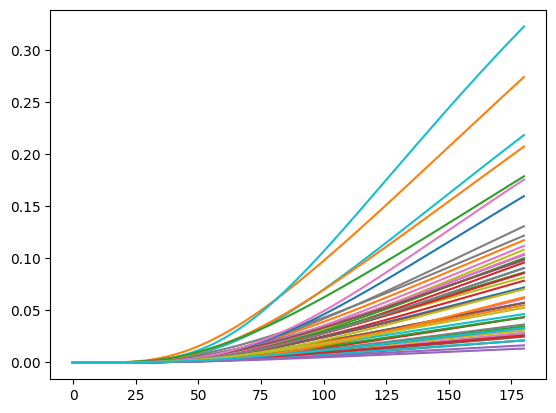

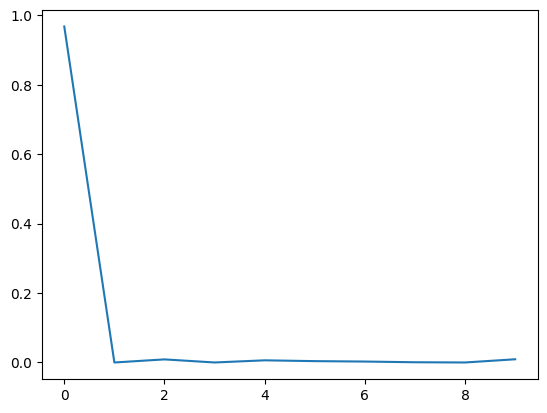

In [78]:
best_pytree = param_reshaper.reshape_single(strategy_state.best_member)
best_control = eqx.combine(best_pytree, control_static_pytree)
best_piecewise_control = build_control(jnp.asarray([0.1]), best_control)

key, subkey = jax.random.split(key)
ys, _ = integrate(best_piecewise_control, environment_state, subkey)
tbid_fraction = ys[..., 12] / (ys[..., 3] + ys[..., 12])

plt.figure()
plt.plot(tbid_fraction.T)
plt.show()

plt.figure()
plt.plot(best_piecewise_control.control)
plt.show()

# Training a neural network

In [ ]:
key = jax.random.PRNGKey(1234)
key, subkey = jax.random.split(key)

model = eqx.nn.MLP(16, 16, 64, 4, key=subkey)
param_reshaper = evosax.ParameterReshaper(eqx.filter(model, eqx.is_array))

key, subkey1, subkey2 = jax.random.split(key, 3)
data_x = jax.random.uniform(subkey1, shape=(8, 16))
data_y = jax.random.uniform(subkey2, shape=(8, 16))


def reward_fn(model_params, model_static):
    model = eqx.combine(model_params, model_static)
    return jnp.mean(jnp.square(jax.vmap(model)(data_x) - data_y))


population_reward_fn = jax.vmap(reward_fn, in_axes=(0, None), out_axes=0)

strategy = evosax.GESMR_GA(popsize=64, num_dims=param_reshaper.total_params)
strategy_params = strategy.default_params
strategy_state = strategy.initialize(key, strategy_params)


@eqx.filter_jit
def evo_step(
    model_static_pytree,
    param_reshaper,
    fitness_fn,
    strategy,
    strategy_params,
    strategy_state,
    key,
):
    model_params_flat, strategy_state = strategy.ask(
        key, strategy_state, strategy_params
    )

    model_params_pytree = param_reshaper.reshape(model_params_flat)
    fitness = fitness_fn(model_params_pytree, model_static_pytree)

    strategy_state = strategy.tell(
        model_params_flat, fitness, strategy_state, strategy_params
    )

    return strategy_state


model_static_pytree = eqx.filter(model, eqx.is_array, inverse=True)

In [ ]:
for i in trange(1024):
    key, subkey = jax.random.split(key)
    strategy_state = evo_step(
        model_static_pytree,
        param_reshaper,
        population_reward_fn,
        strategy,
        strategy_params,
        strategy_state,
        subkey,
    )

In [ ]:
model_params_pytree = param_reshaper.reshape_single(strategy_state.best_member)
reward_fn(model_params_pytree, model_static_pytree)

# Simple test on convex function

In [ ]:
key = jax.random.PRNGKey(1234)
strategy = evosax.CMA_ES(popsize=64, num_dims=2)
strategy_params = strategy.default_params
strategy_state = strategy.initialize(key, strategy_params)


def fitness_fn(x):
    return jnp.mean((x - 1) ** 2, axis=1)


for i in range(128):
    key, subkey = jax.random.split(key)
    x, strategy_state = strategy.ask(subkey, strategy_state, strategy_params)
    fitness = fitness_fn(x)
    strategy_state = strategy.tell(x, fitness, strategy_state, strategy_params)

In [ ]:
strategy_state.best_member, strategy_state.best_fitness